## Rohlik orders forecasts
This notebook contains a time series forecasting task with Rohlik dataset EDA and data preprocessing and as an engine using LSTM model with Tensorflow 2 backend. 

<br><b>Approach:</b>
<br>As Rohlík orders dataset contains data from multiple warehouses, thus it contains multiple timelines, the approach is to process and predict each warehouse as a separate timeline. The preprocessing, fiting and evaluation steps are the same for each warehouse.

<br>This approach yields very good MAPE value, which is calculated as a mean of all warehouse timeline results.

In [1]:
! pip -q install pandas matplotlib numpy seaborn
! pip install -q scikit-learn
! pip install -q joblib
! pip install -q tensorflow

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Bidirectional, BatchNormalization, Input
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import joblib
import os
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from scipy import interpolate


TIME_STEPS = 56
EPOCHS = 1
BATCH_SIZE = 32
WAREHOUSE = "None" # For testing purposes

# Temporal features
#LAG_DAYS = [7, 28, 56, 84, 168, 364]
#ROLLING_WINDOW = [28, 168, 364]
LAG_DAYS = [56, 84, 168, 364]
ROLLING_WINDOW = [56, 168, 364]

pd.set_option('display.max_columns', None)

train_df_raw = pd.read_csv("data/train.csv")
train_calendar_df_raw = pd.read_csv("data/train_calendar.csv")
test_df_raw = pd.read_csv("data/test.csv")
test_calendar_df_raw = pd.read_csv("data/test_calendar.csv")

train_df_raw['date'] = pd.to_datetime(train_df_raw['date'])
train_calendar_df_raw['date'] = pd.to_datetime(train_calendar_df_raw['date'])
test_df_raw['date'] = pd.to_datetime(test_df_raw['date'])
test_calendar_df_raw['date'] = pd.to_datetime(test_calendar_df_raw['date'])

### Optional Dataset Validation

Evaluate the data correctness. Check both .csvs if their values in the same columns match and then merge them into one dataset.

In [3]:
def merge_csv(train_df, train_calendar_df):
    # Identify common columns
    common_columns = set(train_df.columns).intersection(set(train_calendar_df.columns))
    print(common_columns)

    # Merg the two datasets on warehouse and date
    merged_df_to_test = pd.merge(train_df, train_calendar_df, on=['date', 'warehouse'], suffixes=('_train', '_calendar'))
    
        # Compare values in common columns
    differences = {}
    for column in common_columns:
        if column not in ['date', 'warehouse']:  # Exclude join keys from comparison
            train_col = f"{column}_train"
            calendar_col = f"{column}_calendar"
            
            # Check if there are any differences, excluding rows where both values are NaN
            diff = merged_df_to_test[(merged_df_to_test[train_col] != merged_df_to_test[calendar_col]) & 
                            (~merged_df_to_test[train_col].isna() | ~merged_df_to_test[calendar_col].isna())]
            if not diff.empty:
                differences[column] = diff[['date', 'warehouse', train_col, calendar_col]]
            else:
                print(f"No differences found in column: {column}")

    # Display only the rows where values were different
    for col, diff in differences.items():
        print(f"\nNot merged. Differences found in column: {col}")
        print(diff)
        return

    if not differences:
        print("\nSuccess. All values match across the datasets, datasets merged.")
        return pd.merge(train_df, train_calendar_df, on=list(common_columns))


In [4]:
# Merg the two datasets on 'date' and 'warehouse' to facilitate comparison
train_df_merged = merge_csv(train_df_raw, train_calendar_df_raw)
test_df_merged = merge_csv(test_df_raw, test_calendar_df_raw) 

{'holiday', 'holiday_name', 'blackout', 'school_holidays', 'winter_school_holidays', 'warehouse', 'date', 'snow', 'shutdown', 'precipitation', 'mini_shutdown', 'shops_closed', 'frankfurt_shutdown', 'mov_change'}
No differences found in column: holiday
No differences found in column: holiday_name
No differences found in column: blackout
No differences found in column: school_holidays
No differences found in column: winter_school_holidays
No differences found in column: snow
No differences found in column: shutdown
No differences found in column: precipitation
No differences found in column: mini_shutdown
No differences found in column: shops_closed
No differences found in column: frankfurt_shutdown
No differences found in column: mov_change

Success. All values match across the datasets, datasets merged.
{'holiday', 'shops_closed', 'holiday_name', 'school_holidays', 'winter_school_holidays', 'warehouse', 'date'}
No differences found in column: holiday
No differences found in column: sho

In [5]:
train_df = train_df_merged.sort_values(by=['date', 'warehouse'])
test_df = test_df_merged.sort_values(by=['date', 'warehouse'])

### Drop unnecesary data
There are some data in the training set that will not be availiable in the testing / inference data inputs.

In [6]:
# get features that are not available in the test dataset
unavailable_features = list(set(train_df.columns).difference(set(test_df.columns)))    
unavailable_features.remove('orders')

print(f"Common features: {unavailable_features}")

Common features: ['blackout', 'warehouse_limited', 'user_activity_1', 'user_activity_2', 'snow', 'precipitation', 'mini_shutdown', 'shutdown', 'frankfurt_shutdown', 'mov_change']


In [7]:
train_df = train_df.drop(columns=unavailable_features)

In [8]:
# list redundant columns that have unchanging values
# There are unchanging values in single particular warehouse timelines, but we leave it as is.

unchanging_columns = []
for column in train_df.columns:
    if train_df[column].nunique() == 1:
        unchanging_columns.append(column)
print(unchanging_columns)

train_df = train_df.drop(columns=unchanging_columns)

[]


In [9]:
# Some features with little movement, not sure what value do these features bring to the model, as they are unbalanced among timelines, but we leave them for now.

for warehouse in train_df['warehouse'].unique():
    print(f"\nWarehouse: {warehouse}")
    for feature in train_df.columns:
        values = train_df[feature].nunique()
        if values == 2:
            print(f"Feature {feature} has {values} unique values")
            # list values only for the current warehouse:
            print(sum(train_df[train_df['warehouse']==warehouse][feature]==1))


Warehouse: Brno_1
Feature holiday has 2 unique values
45
Feature shops_closed has 2 unique values
20
Feature winter_school_holidays has 2 unique values
28
Feature school_holidays has 2 unique values
0

Warehouse: Budapest_1
Feature holiday has 2 unique values
9
Feature shops_closed has 2 unique values
0
Feature winter_school_holidays has 2 unique values
6
Feature school_holidays has 2 unique values
0

Warehouse: Prague_1
Feature holiday has 2 unique values
45
Feature shops_closed has 2 unique values
20
Feature winter_school_holidays has 2 unique values
84
Feature school_holidays has 2 unique values
0

Warehouse: Prague_2
Feature holiday has 2 unique values
45
Feature shops_closed has 2 unique values
20
Feature winter_school_holidays has 2 unique values
28
Feature school_holidays has 2 unique values
0

Warehouse: Prague_3
Feature holiday has 2 unique values
45
Feature shops_closed has 2 unique values
20
Feature winter_school_holidays has 2 unique values
28
Feature school_holidays has 2

In [10]:
print(train_df.columns)
print(f"train data: {train_df.shape}")
print(f"test data: {test_df.shape}")

Index(['warehouse', 'date', 'orders', 'holiday_name', 'holiday',
       'shops_closed', 'winter_school_holidays', 'school_holidays', 'id'],
      dtype='object')
train data: (7340, 9)
test data: (397, 8)


In [11]:
print(train_df.isnull().sum())
print(test_df.isnull().sum())

warehouse                    0
date                         0
orders                       0
holiday_name              7122
holiday                      0
shops_closed                 0
winter_school_holidays       0
school_holidays              0
id                           0
dtype: int64
warehouse                   0
date                        0
holiday_name              380
holiday                     0
shops_closed                0
winter_school_holidays      0
school_holidays             0
id                          0
dtype: int64


In [12]:
test_df.head()

,warehouse,date,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,id
61,Brno_1,2024-03-16,NaN,0,0,0,0,Brno_1_2024-03-16
340,Budapest_1,2024-03-16,NaN,0,0,0,0,Budapest_1_2024-03-16
292,Frankfurt_1,2024-03-16,NaN,0,0,0,0,Frankfurt_1_2024-03-16
244,Munich_1,2024-03-16,NaN,0,0,0,0,Munich_1_2024-03-16
0,Prague_1,2024-03-16,NaN,0,0,0,0,Prague_1_2024-03-16


In [13]:
# What is the gap between the date of the last training data and the first test data?
train_max_date = train_df['date'].max()
test_min_date = test_df['date'].min()
print(f"Train max date: {train_max_date}")
print(f"Test min date: {test_min_date}")
print(f"Gap: {test_min_date - train_max_date}")

Train max date: 2024-03-15 00:00:00
Test min date: 2024-03-16 00:00:00
Gap: 1 days 00:00:00


In [14]:
# merge the two datasets to facilitate data preprocessing and lag features generation   
train_df = pd.concat([train_df, test_df], axis=0)

In [15]:
train_df = train_df.sort_values(by=['date', 'warehouse'])

In [16]:
# only get data of one warehouse for the dataset
if WAREHOUSE != "None":
    train_df = train_df[train_df['warehouse'] == WAREHOUSE]

In [17]:
from math import pi

def process_date(df):
    df.index = df.pop('date')
    
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['day_of_week'] = df.index.dayofweek
    df['day_of_year'] = df.index.dayofyear
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    
    df['days_since_start'] = (df.index - df.index.min()).days
    
    df['year_sin'] = df['year'] * np.sin(2 * pi * df['year'])
    df['year_cos'] = df['year'] * np.cos(2 * pi * df['year'])
    df['month_sin'] = df['month'] * np.sin(2 * pi * df['month'])
    df['month_cos'] = df['month'] * np.cos(2 * pi * df['month'])
    df['day_sin'] = df['day'] * np.sin(2 * pi * df['day'])
    df['day_cos'] = df['day'] * np.cos(2 * pi * df['day'])
    
    time_features = ['day', 'days_since_start', 'month', 'day_of_year', 'year_sin', 'year_cos', 'month_sin', 'month_cos', 'day_cos', 'day_sin']
    categorical_features = ['day_of_week', 'quarter', 'year'] 
    binary_features = ['is_weekend']
    return df, time_features, categorical_features, binary_features

### Features categories:
- time_features
- numerical_features
- categorical_features

In [18]:
train_df, time_features, categorical_features, binary_features=process_date(train_df)
binary_features = binary_features + ['holiday', 'shops_closed', 'winter_school_holidays', 'school_holidays']

In [19]:
train_df = train_df.drop(columns=['holiday_name']) 

### Plot

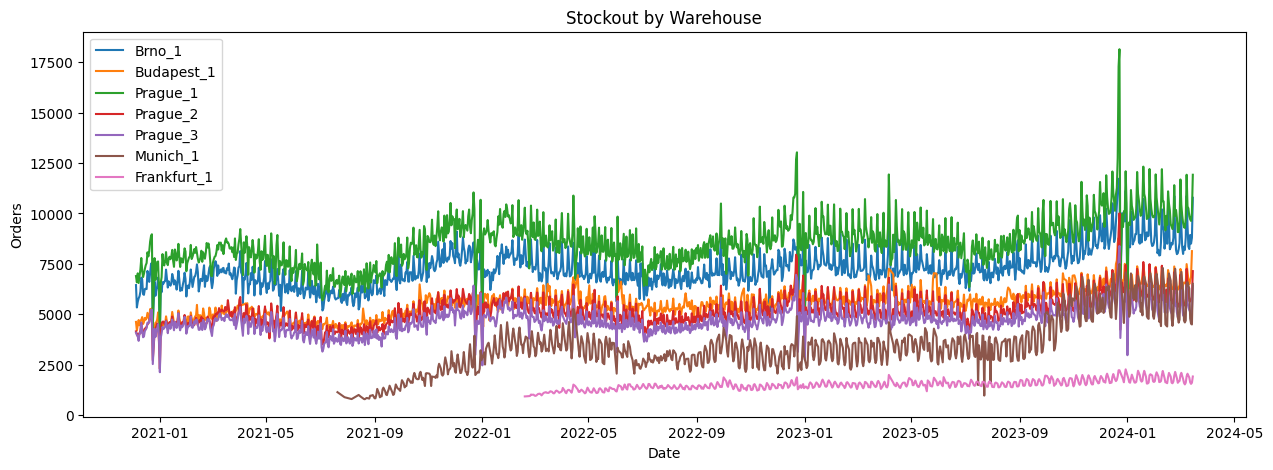

In [20]:
# Visualise the data
plt.figure(figsize=(15, 5))
for warehouse in train_df['warehouse'].unique():
    warehouse_df = train_df[train_df['warehouse'] == warehouse]
    plt.plot(warehouse_df.index, warehouse_df['orders'], label=warehouse)
plt.title("Stockout by Warehouse")
plt.xlabel("Date")
plt.ylabel("Orders")
plt.legend()
plt.show()

<Axes: title={'center': 'Distribution'}, xlabel='Orders', ylabel='Frequency'>

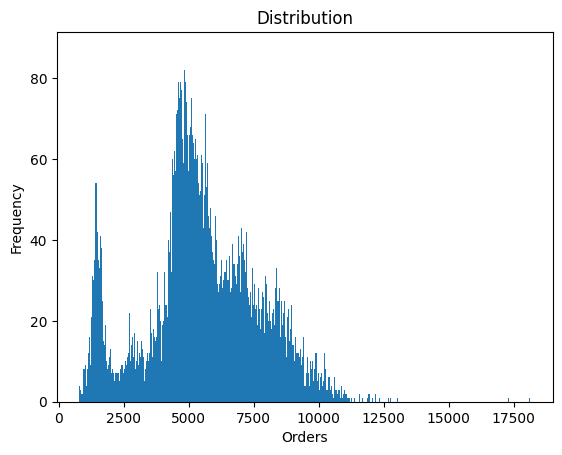

In [21]:
train_df['orders'].plot(kind='hist', bins=500, title='Distribution', xlabel='Orders')

<Axes: xlabel='date'>

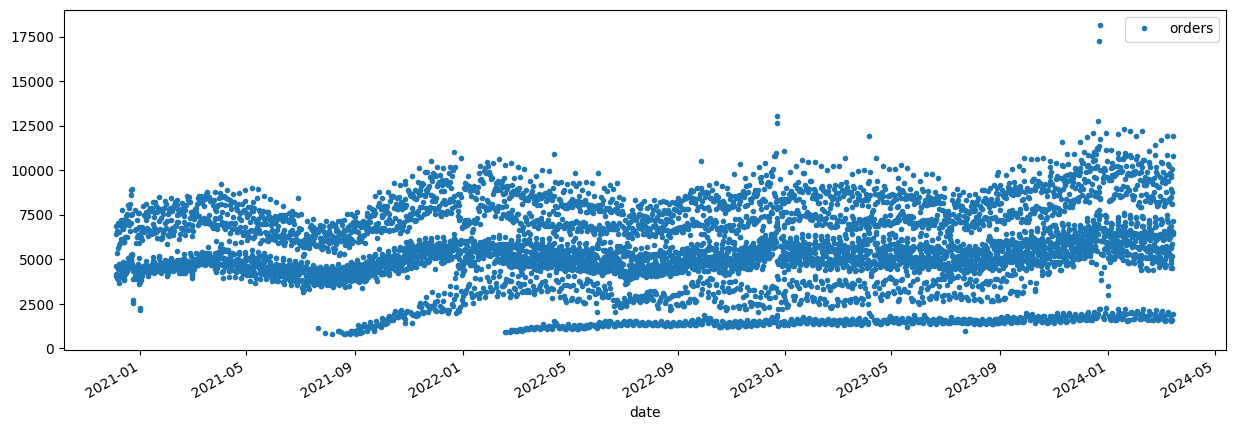

In [22]:
train_df.query('orders > 500').plot(y='orders', figsize=(15, 5), style='.')

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def z_score_outlier_detection(data, window=14, threshold=3):
    data = data.sort_index()
    rolling_mean = data.rolling(window=window, center=True, min_periods=1).mean()
    rolling_std = data.rolling(window=window, center=True, min_periods=1).std()
    z_scores = (data - rolling_mean) / rolling_std
    outliers = np.abs(z_scores) > threshold
    lower_bound = rolling_mean - (threshold * rolling_std)
    upper_bound = rolling_mean + (threshold * rolling_std)
    return outliers, lower_bound, upper_bound

def fix_outliers(data, outliers, window=14):
    fixed_data = data.copy()
    fixed_data[outliers] = np.nan
    fixed_data = fixed_data.interpolate()
    return fixed_data

def plot_outlier_comparison(train_df, window=28, z_threshold=3):
    warehouses = train_df['warehouse'].unique()
    n_warehouses = len(warehouses)
    
    n_cols = 1
    n_rows = n_warehouses
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 10*n_rows))
    axes = axes.flatten() if n_warehouses > 1 else [axes]
    
    all_z_outliers = pd.Series(dtype=bool)
    
    for idx, warehouse in enumerate(warehouses):
        warehouse_data = train_df[train_df['warehouse'] == warehouse]['orders']
        
        z_outliers, z_lower, z_upper = z_score_outlier_detection(warehouse_data, window, z_threshold)
        fixed_warehouse_data = fix_outliers(warehouse_data, z_outliers, window=window)
        
        # Update the original DataFrame with fixed values
        train_df.loc[train_df['warehouse'] == warehouse, 'orders'] = fixed_warehouse_data
        
        all_z_outliers = pd.concat([all_z_outliers, z_outliers])
        
        # Plot the original data and outliers
        ax = axes[idx]
        ax.plot(warehouse_data.index, warehouse_data, label='Orders', alpha=0.7)
        
        # Plot Z-Score bounds and outliers
        ax.fill_between(warehouse_data.index, z_lower, z_upper, color='green', alpha=0.1, label='Z-Score Bounds')
        ax.scatter(warehouse_data.index[z_outliers], warehouse_data[z_outliers], color='green', label='Z-Score Outliers', marker='s')
        
        # Plot fixed outliers
        ax.scatter(warehouse_data.index[z_outliers], fixed_warehouse_data[z_outliers], color='orange', label='Fixed Outliers', marker='x')

        ax.set_title(f'{warehouse} - Outlier Comparison')
        ax.set_xlabel('Date')
        ax.set_ylabel('Orders')
        ax.legend()
        ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary of outliers for each warehouse
    for warehouse in warehouses:
        warehouse_data = train_df[train_df['warehouse'] == warehouse]['orders']
        z_outliers, _, _ = z_score_outlier_detection(warehouse_data, window, z_threshold)
        
        print(f"\n{warehouse}:")
        print(f"Z-Score Outliers: {sum(z_outliers)}")
    
    return train_df




In [24]:
#train_df = plot_outlier_comparison(train_df, window=180, z_threshold=2.8)

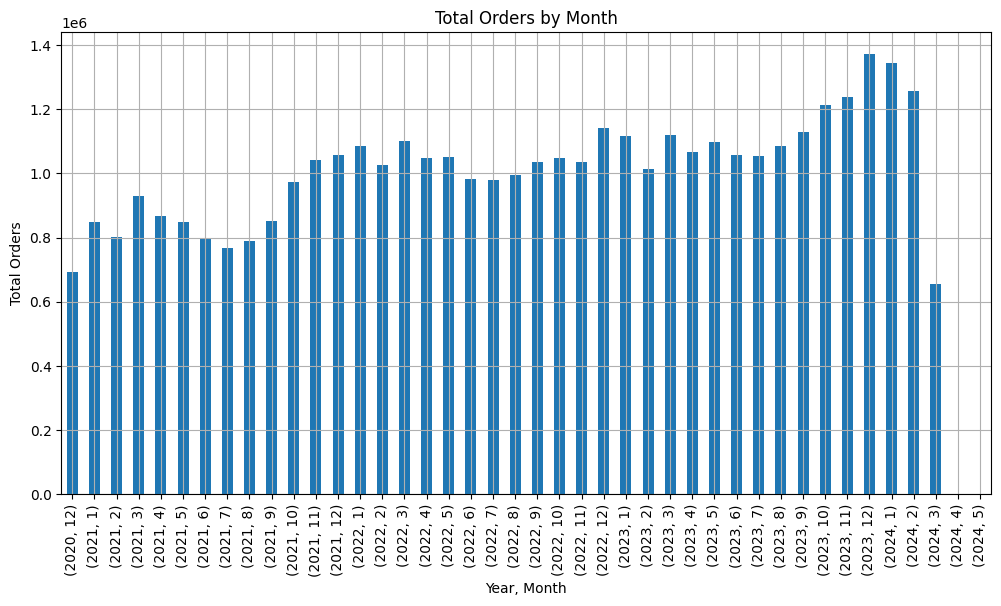

In [25]:

# plot the orders
df_by_month = train_df.groupby(['year', 'month'])['orders'].sum()
df_by_month.plot(kind='bar', figsize=(12, 6))

plt.title('Total Orders by Month')
plt.ylabel('Total Orders')
plt.xlabel('Year, Month')
plt.xticks(np.arange(len(df_by_month)), df_by_month.index, rotation=90)
plt.grid(True)
plt.show()


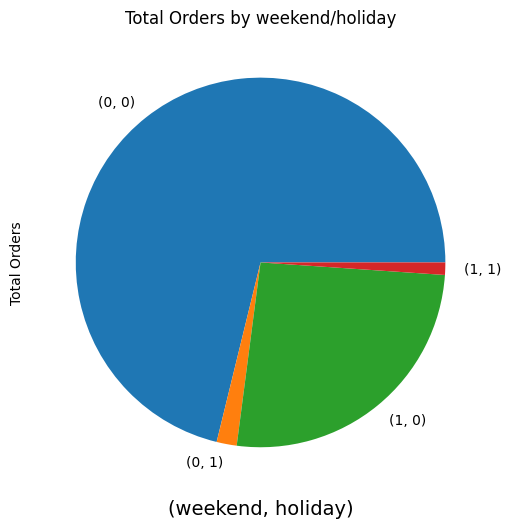

In [26]:
# plot the orders
df_by_month = train_df.groupby(['is_weekend', 'holiday'])['orders'].sum()
df_by_month.plot(kind='pie', figsize=(12, 6))

plt.title('Total Orders by weekend/holiday')
plt.ylabel('Total Orders')
plt.xlabel('(weekend, holiday)', fontdict={'fontsize': 14})
plt.show()

#### Compare feature Colerations

In [27]:
train_df_corr = train_df.drop(columns=['warehouse', "id"]).corr()

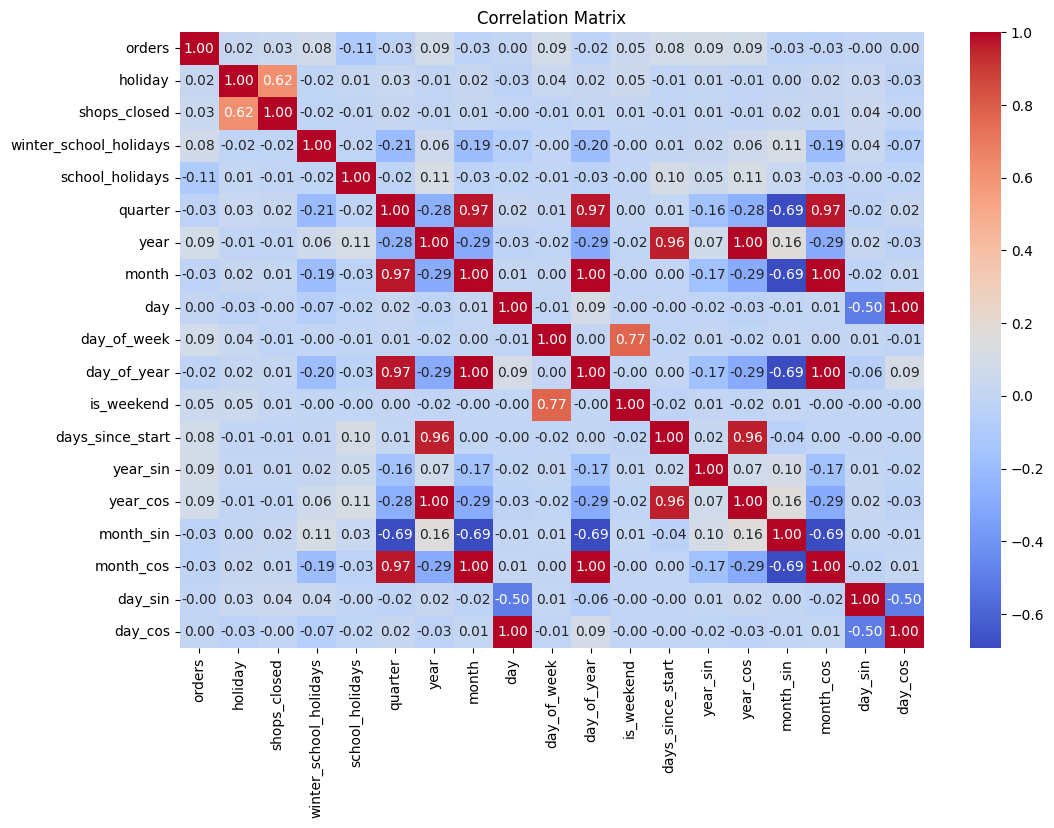

orders                    1.000000
year_sin                  0.087547
day_of_week               0.086522
year                      0.085920
year_cos                  0.085920
days_since_start          0.080793
winter_school_holidays    0.077211
is_weekend                0.046594
shops_closed              0.034824
holiday                   0.018006
day                       0.002689
day_cos                   0.002689
day_sin                  -0.003553
day_of_year              -0.024332
month                    -0.025271
month_cos                -0.025271
month_sin                -0.029229
quarter                  -0.029323
school_holidays          -0.105071
Name: orders, dtype: float64


In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(train_df_corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Print the correlation with 'orders'
print(train_df_corr['orders'].sort_values(ascending=False))

### Temporal features

In [29]:
def create_lag_features(df, col, lag_days):
    df = df.copy() 
    lag_features = []
    for lag in lag_days:
        feature_name = f'{col}_lag_{lag}'
        df[feature_name] = df.groupby('warehouse')[col].shift(lag)
        lag_features.append(feature_name)
    return df, lag_features

def create_rolling_features(df, col, windows):
    df = df.copy()
    window_features = []
    for window in windows:
        mean_feature = f'{col}_rolling_mean_{window}'
        std_feature = f'{col}_rolling_std_{window}'
        
        df[mean_feature] = df.groupby('warehouse')[col].transform(lambda x: x.rolling(window, min_periods=1).mean())
        df[std_feature] = df.groupby('warehouse')[col].transform(lambda x: x.rolling(window, min_periods=1).std())
        
        window_features.extend([mean_feature, std_feature])
    return df, window_features

def create_and_process_features(df, lag_days, rolling_window, fill_method='ffill'):
    df, lag_features = create_lag_features(df, 'orders', lag_days)
    df, window_features = create_rolling_features(df, 'orders', rolling_window)
    
    if fill_method == 'ffill':
        df[lag_features + window_features] = df[lag_features + window_features].ffill().bfill()
    elif fill_method == 'zero':
        df[lag_features + window_features] = df[lag_features + window_features].fillna(0)
    else:
        raise ValueError("Invalid fill method. Choose 'ffill' or 'zero'.")
    
    return df, lag_features, window_features

In [30]:
# Process each warehouse separately
warehouses = train_df['warehouse'].unique()
all_warehouses_data = []

for warehouse in warehouses:
    warehouse_df = train_df[train_df['warehouse'] == warehouse]
    warehouse_df, lag_features, window_features = create_and_process_features(warehouse_df, LAG_DAYS, ROLLING_WINDOW, fill_method='ffill')
    all_warehouses_data.append(warehouse_df)
    
# Concatenate all warehouse data back together (to export the test part later)
train_df = pd.concat(all_warehouses_data)

# Im ordering my features into categories for clarity
numerical_features = ['orders']
numerical_features += lag_features + window_features
categorical_features = categorical_features

print(numerical_features)

train_df.head()

['orders', 'orders_lag_56', 'orders_lag_84', 'orders_lag_168', 'orders_lag_364', 'orders_rolling_mean_56', 'orders_rolling_std_56', 'orders_rolling_mean_168', 'orders_rolling_std_168', 'orders_rolling_mean_364', 'orders_rolling_std_364']


,warehouse,orders,holiday,shops_closed,winter_school_holidays,school_holidays,id,quarter,year,month,day,day_of_week,day_of_year,is_weekend,days_since_start,year_sin,year_cos,month_sin,month_cos,day_sin,day_cos,orders_lag_56,orders_lag_84,orders_lag_168,orders_lag_364,orders_rolling_mean_56,orders_rolling_std_56,orders_rolling_mean_168,orders_rolling_std_168,orders_rolling_mean_364,orders_rolling_std_364
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-12-05,Brno_1,6447.0,0,0,0,0,Brno_1_2020-12-05,4,2020,12,5,5,340,1,0,-1.630940e-09,2020.0,-3.526983e-14,12.0,-6.123234e-15,5.0,6447.0,6447.0,6447.0,6447.0,6447.0,784.181420,6447.0,784.181420,6447.0,784.181420
2020-12-06,Brno_1,5338.0,0,0,0,0,Brno_1_2020-12-06,4,2020,12,6,6,341,1,1,-1.630940e-09,2020.0,-3.526983e-14,12.0,-8.817457e-15,6.0,6447.0,6447.0,6447.0,6447.0,5892.5,784.181420,5892.5,784.181420,5892.5,784.181420
2020-12-07,Brno_1,5621.0,0,0,0,0,Brno_1_2020-12-07,4,2020,12,7,0,342,0,2,-1.630940e-09,2020.0,-3.526983e-14,12.0,-1.200154e-14,7.0,6447.0,6447.0,6447.0,6447.0,5802.0,576.229989,5802.0,576.229989,5802.0,576.229989
2020-12-08,Brno_1,5792.0,0,0,0,0,Brno_1_2020-12-08,4,2020,12,8,1,343,0,3,-1.630940e-09,2020.0,-3.526983e-14,12.0,-1.567548e-14,8.0,6447.0,6447.0,6447.0,6447.0,5799.5,470.516383,5799.5,470.516383,5799.5,470.516383
2020-12-09,Brno_1,5894.0,0,0,0,0,Brno_1_2020-12-09,4,2020,12,9,2,344,0,4,-1.630940e-09,2020.0,-3.526983e-14,12.0,-1.983928e-14,9.0,6447.0,6447.0,6447.0,6447.0,5818.4,409.664863,5818.4,409.664863,5818.4,409.664863


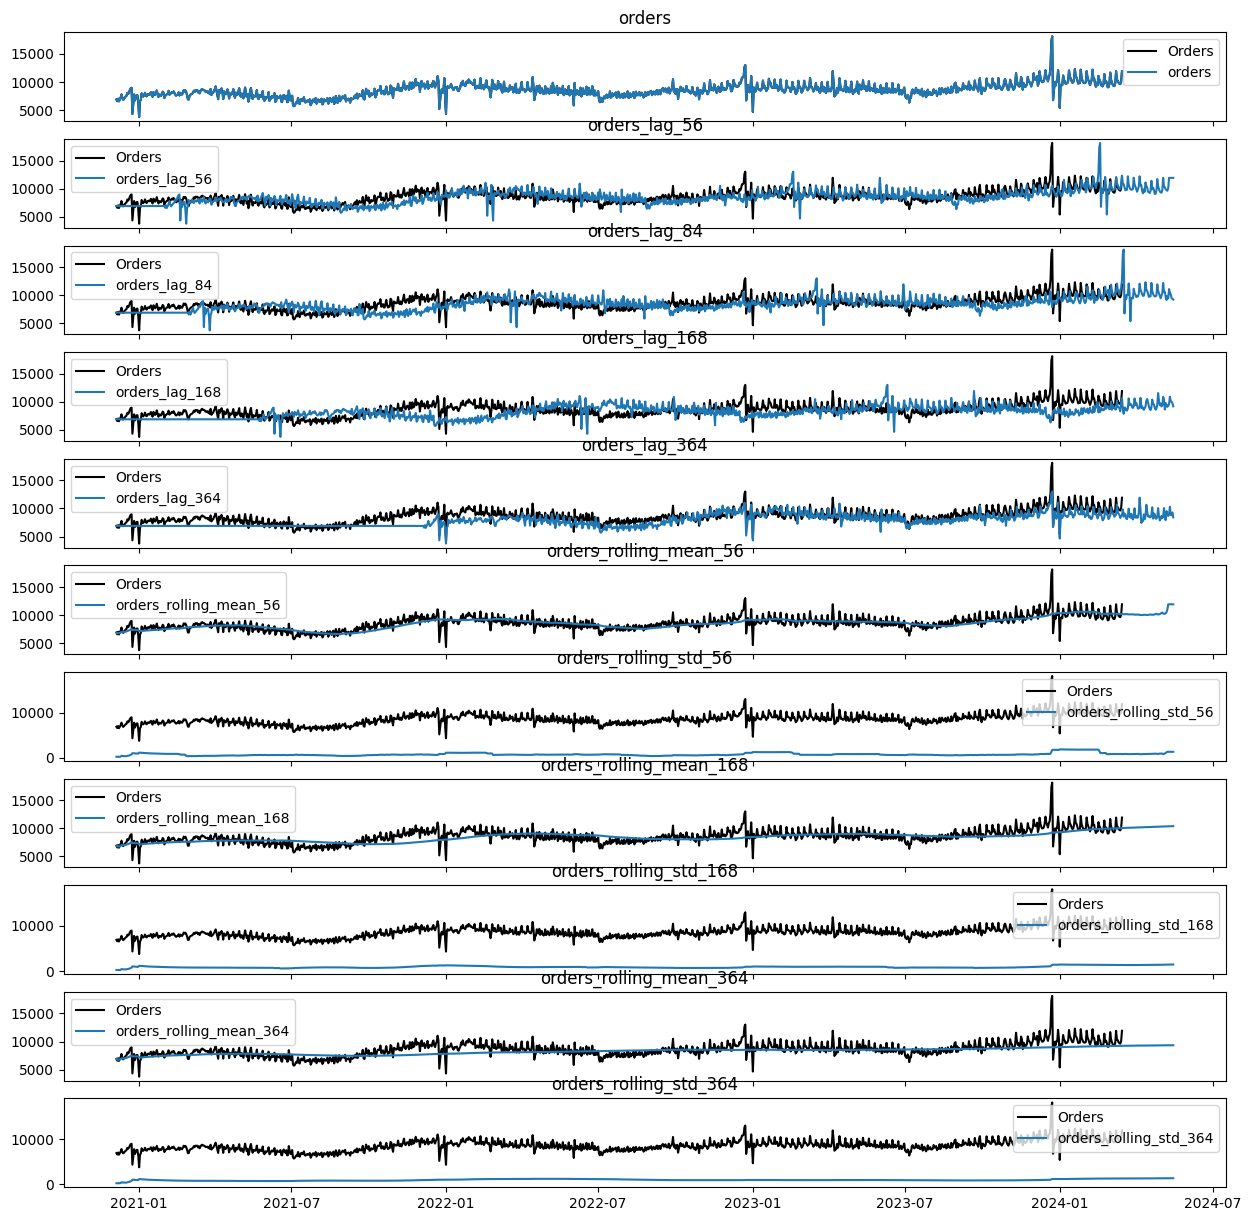

In [31]:
#orders and features above each other
fig, ax = plt.subplots(len(numerical_features), 1, figsize=(15, 15), sharex=True)
for i, feature in enumerate(numerical_features):
    ax[i].plot(train_df[train_df.warehouse == "Prague_1"].index, train_df[train_df.warehouse == 'Prague_1'].orders, label='Orders', color='black')
    ax[i].plot(train_df[train_df.warehouse == 'Prague_1'].index, train_df[train_df.warehouse == 'Prague_1'][feature], label=feature)
    ax[i].set_title(feature)
    ax[i].legend()
plt.show()


In [32]:
# divide dataset back into train and test datasets, for test set to export with new features and train to train on.
test_date_range = (test_df_merged.date.min(), test_df_merged.date.max())
train_date_range = (train_df_merged.date.min(), train_df_merged.date.max())

test_df = train_df.loc[(train_df.index >= test_date_range[0]) & (train_df.index <= test_date_range[1])]
test_df = test_df.drop(columns=['orders'])
train_df = train_df.loc[(train_df.index >= train_date_range[0]) & (train_df.index <= train_date_range[1])]

In [33]:
train_df.tail()

,warehouse,orders,holiday,shops_closed,winter_school_holidays,school_holidays,id,quarter,year,month,day,day_of_week,day_of_year,is_weekend,days_since_start,year_sin,year_cos,month_sin,month_cos,day_sin,day_cos,orders_lag_56,orders_lag_84,orders_lag_168,orders_lag_364,orders_rolling_mean_56,orders_rolling_std_56,orders_rolling_mean_168,orders_rolling_std_168,orders_rolling_mean_364,orders_rolling_std_364
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-03-11,Frankfurt_1,1867.0,0,0,0,0,Frankfurt_1_2024-03-11,1,2024,3,11,0,71,0,1192,3.208798e-11,2024.0,-2.204364e-15,3.0,-1.077962e-13,11.0,1820.0,1594.0,1385.0,1541.0,1815.571429,198.732425,1731.505952,200.914287,1617.178571,196.048719
2024-03-12,Frankfurt_1,1629.0,0,0,0,0,Frankfurt_1_2024-03-12,1,2024,3,12,1,72,0,1193,3.208798e-11,2024.0,-2.204364e-15,3.0,-3.526983e-14,12.0,2007.0,1818.0,1387.0,1338.0,1808.821429,198.531619,1732.946429,199.290486,1617.978022,195.499698
2024-03-13,Frankfurt_1,1552.0,0,0,0,0,Frankfurt_1_2024-03-13,1,2024,3,13,2,73,0,1194,3.208798e-11,2024.0,-2.204364e-15,3.0,5.097749e-14,13.0,1751.0,1940.0,1558.0,1421.0,1805.267857,201.346422,1732.910714,199.322560,1618.337912,195.256513
2024-03-14,Frankfurt_1,1608.0,0,0,0,0,Frankfurt_1_2024-03-14,1,2024,3,14,3,74,0,1195,3.208798e-11,2024.0,-2.204364e-15,3.0,-4.800615e-14,14.0,1619.0,1803.0,1650.0,1386.0,1805.071429,201.536720,1732.660714,199.453470,1618.947802,194.875138
2024-03-15,Frankfurt_1,1916.0,0,0,0,0,Frankfurt_1_2024-03-15,1,2024,3,15,4,75,0,1196,3.208798e-11,2024.0,-2.204364e-15,3.0,-1.616905e-13,15.0,1611.0,1657.0,1639.0,1324.0,1810.517857,200.314207,1734.309524,199.819168,1620.574176,194.877139


In [34]:
print(f"Train data: {train_df.shape}")
print(f"Test data: {test_df.shape}")

Train data: (7340, 31)
Test data: (397, 30)


In [35]:
# Save test datas for future inference
test_df.to_csv('data/test_proc_mt.csv')

In [36]:
train_df = train_df.drop(columns=['id'])

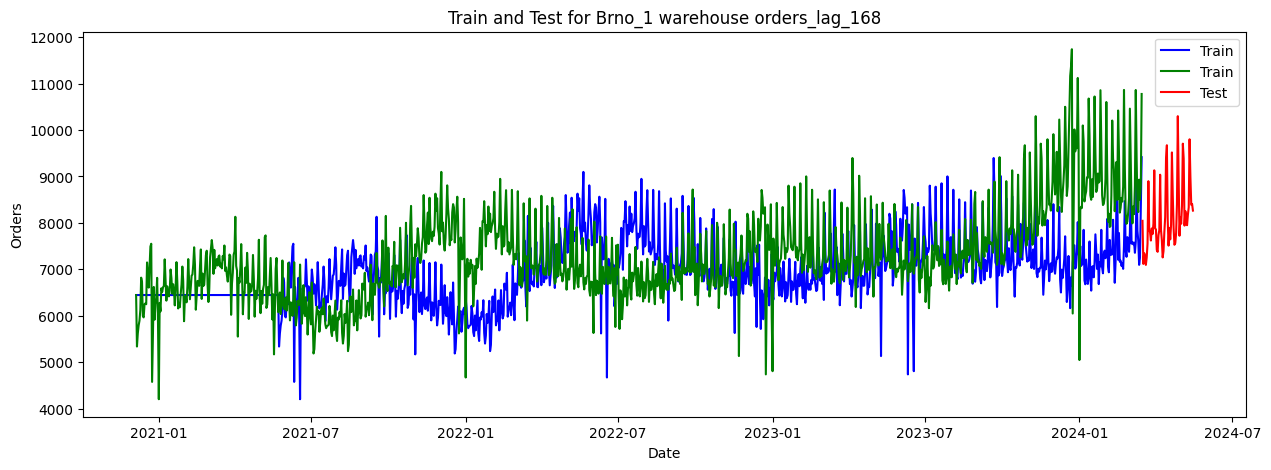

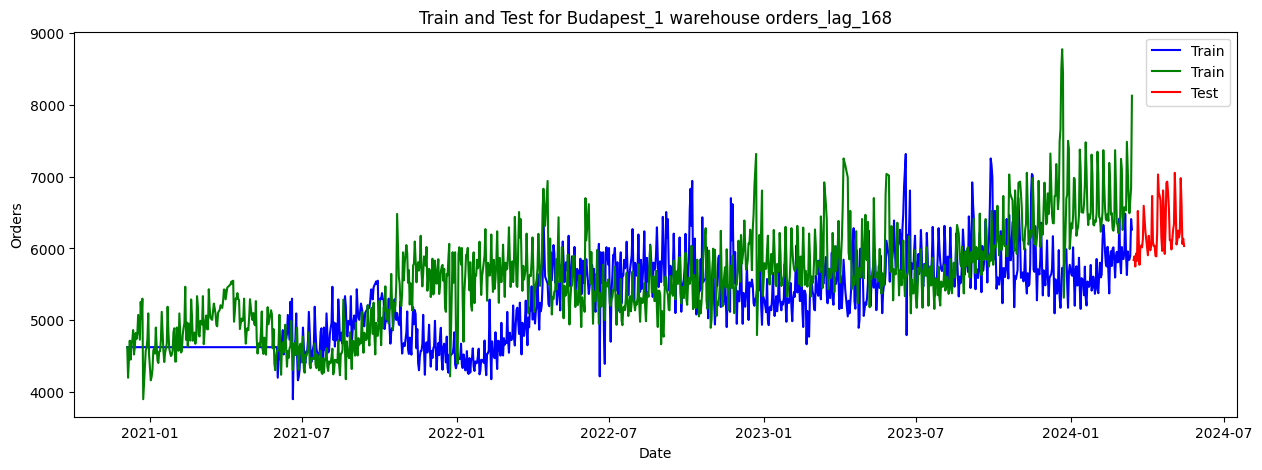

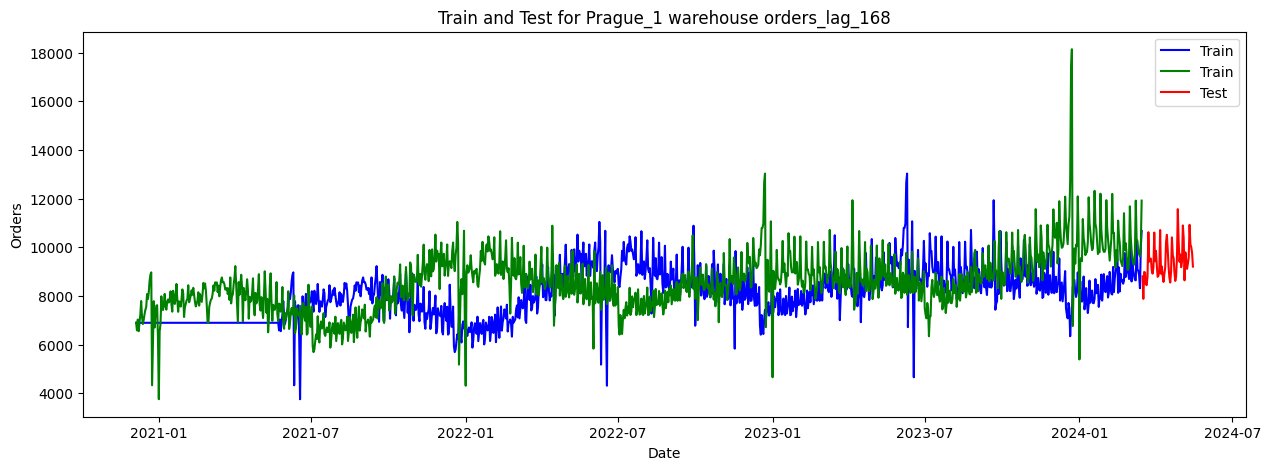

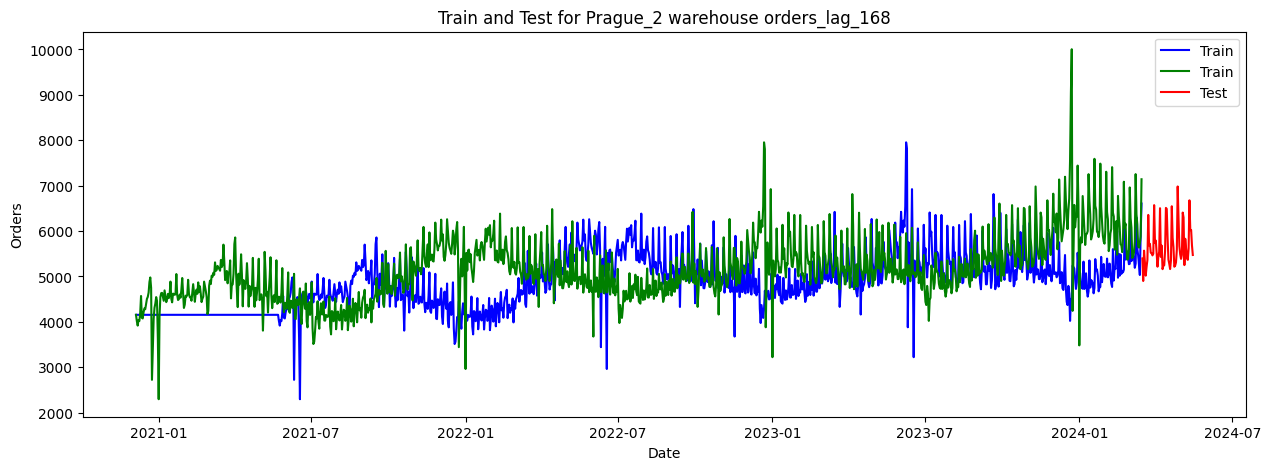

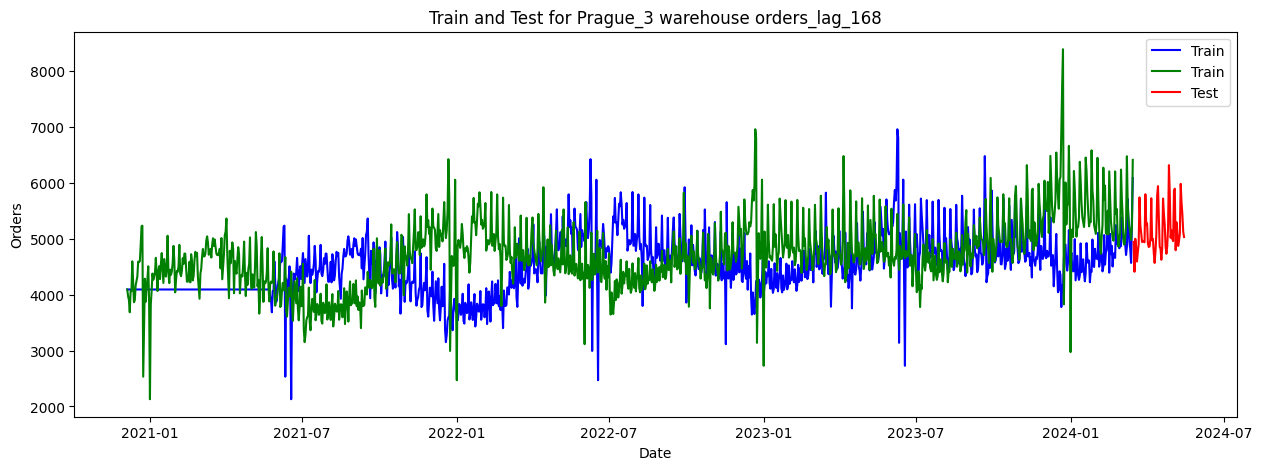

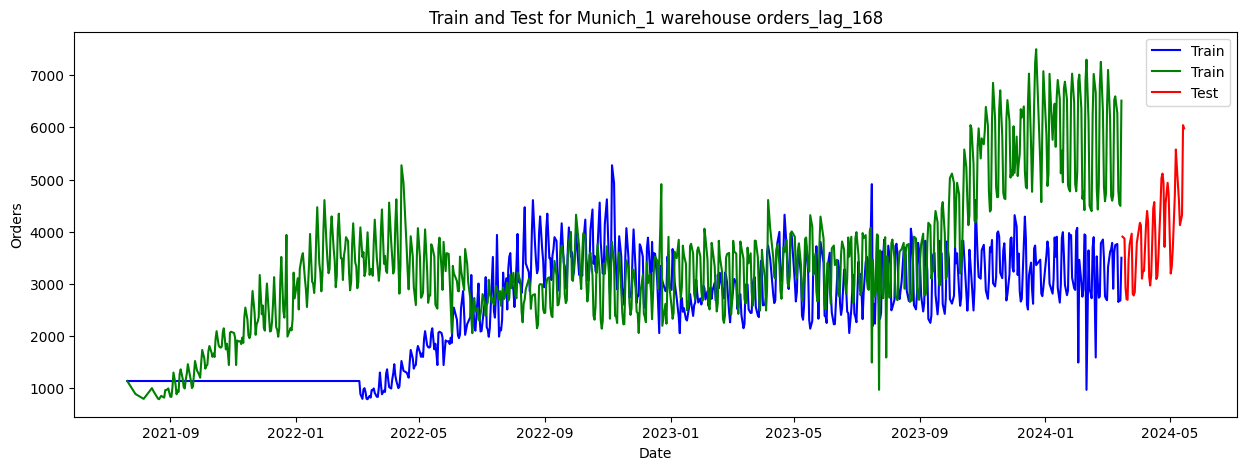

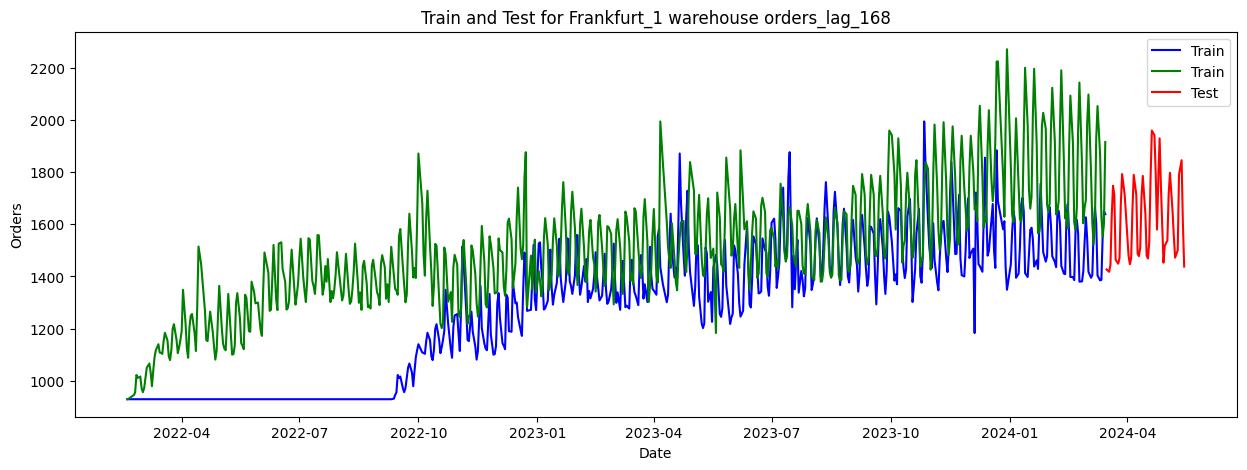

In [37]:
# plot the train and test datasets and visualise them in diferent colors for only column of every warehouse
feature = f'orders_lag_{LAG_DAYS[2]}' # third lag feature for test data

for warehouse in train_df['warehouse'].unique():
    plt.figure(figsize=(15, 5)) 
    datax = train_df[train_df['warehouse'] == warehouse]
    datax_test = test_df[test_df['warehouse'] == warehouse]
    plt.plot(datax.index, datax[feature], label='Train', color='blue')
    plt.plot(datax.index, datax['orders'], label='Train', color='green')
    plt.plot(datax_test.index, datax_test[feature], label='Test', color='red')
    plt.title(f'Train and Test for {warehouse} warehouse {feature}')
    plt.xlabel('Date')
    plt.ylabel('Orders')
    plt.legend()
    plt.show()

In [38]:
print(f"Train data: {train_df.shape}")
print(f"Test data: {test_df.shape}")

Train data: (7340, 30)
Test data: (397, 30)


In [39]:
"""lag_roll features
"""
LAG_ROLL_FEATURES = []
for feature in numerical_features:
    if 'lag' in feature or 'rolling' in feature:
        LAG_ROLL_FEATURES.append(feature)
print(LAG_ROLL_FEATURES)                                             

['orders_lag_56', 'orders_lag_84', 'orders_lag_168', 'orders_lag_364', 'orders_rolling_mean_56', 'orders_rolling_std_56', 'orders_rolling_mean_168', 'orders_rolling_std_168', 'orders_rolling_mean_364', 'orders_rolling_std_364']


In [40]:
x_scaler_features = list(set(train_df.columns) - set(categorical_features) - set(binary_features) - {'warehouse', 'orders'})
print(x_scaler_features)

['day', 'orders_rolling_std_56', 'orders_lag_168', 'orders_lag_84', 'month_cos', 'day_sin', 'month_sin', 'day_cos', 'orders_rolling_std_168', 'year_cos', 'year_sin', 'orders_rolling_mean_56', 'month', 'orders_rolling_mean_168', 'day_of_year', 'days_since_start', 'orders_rolling_mean_364', 'orders_rolling_std_364', 'orders_lag_56', 'orders_lag_364']


In [41]:
print("Start Date:", train_df.index.min())
print("End Date:", train_df.index.max())        

Start Date: 2020-12-05 00:00:00
End Date: 2024-03-15 00:00:00


## Training Loop

In [42]:
def preprocess_data(df, cat_features, x_scaler_features, binary_features, inference=False):
    #if not inference:
        # Create lag and rolling features
        #df, lag_features = create_lag_features(df, 'orders', LAG_DAYS)
        #df, window_features = create_rolling_features(df, 'orders', ROLLING_WINDOW)

        # Handle NaN values in lag and rolling features
        #df[lag_features + window_features] = df[lag_features + window_features].fillna(method='ffill').fillna(method='bfill')
        #df[lag_features + window_features] = df[lag_features + window_features].fillna(0)


    # One-hot encoding for categorical features
    if not inference:
        encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        encoded_features = encoder.fit_transform(df[cat_features])
        joblib.dump(encoder, 'onehot_scaler.joblib')
    else:
        encoder = joblib.load('onehot_scaler.joblib')
        encoded_features = encoder.transform(df[cat_features])

    encoded_feature_names = encoder.get_feature_names_out(cat_features)
    encoded_df = pd.DataFrame(encoded_features, columns=encoded_feature_names, index=df.index)

    ## Prepare features for scaling
    #if not inference:
    #    X = df.drop(columns=['orders'])
    #    y = df['orders']
    #else:
    #    X = df.copy()

    # Initialize and fit/transform scalers
    #if not inference:
    #    x_scaler = StandardScaler()
    #    y_scaler = StandardScaler()
    #    X_scaled = x_scaler.fit_transform(X[x_scaler_features])
    #    y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1))
    #    joblib.dump(x_scaler, 'x_scaler.joblib')
    #    joblib.dump(y_scaler, 'y_scaler.joblib')
    #else:
    #    x_scaler = joblib.load('x_scaler.joblib')
    #    X_scaled = x_scaler.transform(X[x_scaler_features])
    #    y_scaled = None  # No target variable during inference

    # Create DataFrame with scaled features
    #X_scaled_df = pd.DataFrame(X_scaled, columns=x_scaler_features, index=df.index)

    # Combine all features
    final_df = pd.concat([
        df,  # Scaled numerical features
        encoded_df,   # One-hot encoded categorical features
        #df[binary_features]  # Binary features (unchanged)
    ], axis=1)
    

    return final_df


In [43]:
def create_sequences(X_train_scaled, y_train_scaled, time_steps):
    # Create sequences for each warehouse
    
    sequences = []
    targets = []

    if len(X_train_scaled) > time_steps:
        generator = TimeseriesGenerator(X_train_scaled.values, 
                                        y_train_scaled, 
                                        length=time_steps, 
                                        batch_size=1)
        
        for i in range(len(generator)):
            x, y = generator[i]
            sequences.append(x)
            targets.append(y)

    X = np.array(sequences)
    y = np.array(targets)

    X = np.squeeze(X, axis=1)
    y = np.squeeze(y, axis=1)
    
    print(f"final shape: {X.shape, y.shape}")
    
    return X, y

In [44]:
def create_model(input_shape, lr=1e-3):

    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=32, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=16, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(units=1))

    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=lr))

    return model

In [45]:
def plot_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss of {warehouse}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [46]:
print(train_df.isna().sum())

warehouse                  0
orders                     0
holiday                    0
shops_closed               0
winter_school_holidays     0
school_holidays            0
quarter                    0
year                       0
month                      0
day                        0
day_of_week                0
day_of_year                0
is_weekend                 0
days_since_start           0
year_sin                   0
year_cos                   0
month_sin                  0
month_cos                  0
day_sin                    0
day_cos                    0
orders_lag_56              0
orders_lag_84              0
orders_lag_168             0
orders_lag_364             0
orders_rolling_mean_56     0
orders_rolling_std_56      0
orders_rolling_mean_168    0
orders_rolling_std_168     0
orders_rolling_mean_364    0
orders_rolling_std_364     0
dtype: int64


In [47]:
train_df.head()

,warehouse,orders,holiday,shops_closed,winter_school_holidays,school_holidays,quarter,year,month,day,day_of_week,day_of_year,is_weekend,days_since_start,year_sin,year_cos,month_sin,month_cos,day_sin,day_cos,orders_lag_56,orders_lag_84,orders_lag_168,orders_lag_364,orders_rolling_mean_56,orders_rolling_std_56,orders_rolling_mean_168,orders_rolling_std_168,orders_rolling_mean_364,orders_rolling_std_364
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-12-05,Brno_1,6447.0,0,0,0,0,4,2020,12,5,5,340,1,0,-1.630940e-09,2020.0,-3.526983e-14,12.0,-6.123234e-15,5.0,6447.0,6447.0,6447.0,6447.0,6447.0,784.181420,6447.0,784.181420,6447.0,784.181420
2020-12-06,Brno_1,5338.0,0,0,0,0,4,2020,12,6,6,341,1,1,-1.630940e-09,2020.0,-3.526983e-14,12.0,-8.817457e-15,6.0,6447.0,6447.0,6447.0,6447.0,5892.5,784.181420,5892.5,784.181420,5892.5,784.181420
2020-12-07,Brno_1,5621.0,0,0,0,0,4,2020,12,7,0,342,0,2,-1.630940e-09,2020.0,-3.526983e-14,12.0,-1.200154e-14,7.0,6447.0,6447.0,6447.0,6447.0,5802.0,576.229989,5802.0,576.229989,5802.0,576.229989
2020-12-08,Brno_1,5792.0,0,0,0,0,4,2020,12,8,1,343,0,3,-1.630940e-09,2020.0,-3.526983e-14,12.0,-1.567548e-14,8.0,6447.0,6447.0,6447.0,6447.0,5799.5,470.516383,5799.5,470.516383,5799.5,470.516383
2020-12-09,Brno_1,5894.0,0,0,0,0,4,2020,12,9,2,344,0,4,-1.630940e-09,2020.0,-3.526983e-14,12.0,-1.983928e-14,9.0,6447.0,6447.0,6447.0,6447.0,5818.4,409.664863,5818.4,409.664863,5818.4,409.664863


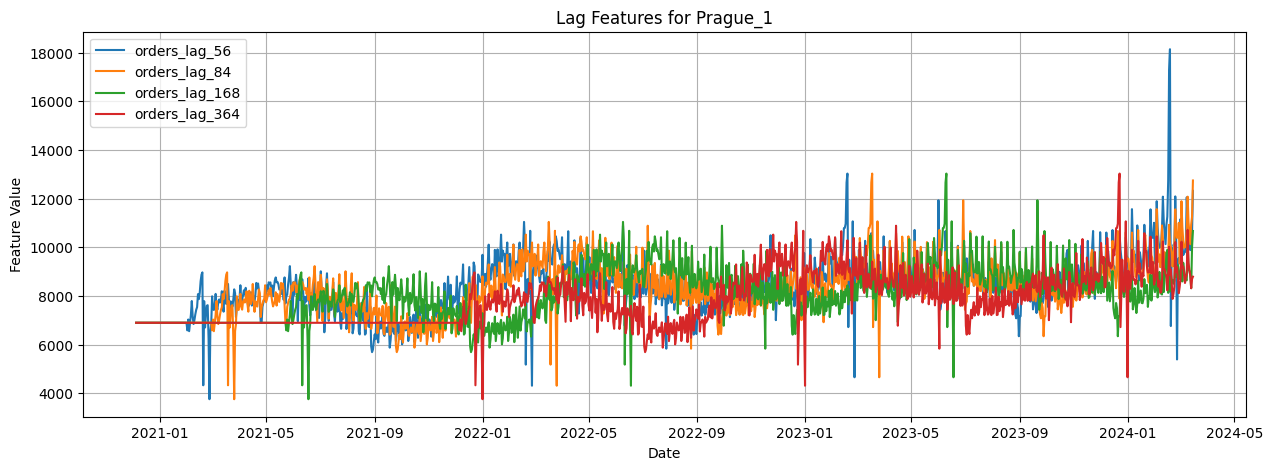

In [48]:
# Define the warehouse you want to plot
warehouse_to_plot = 'Prague_1'

# Filter the data for the selected warehouse
X_train_wh = train_df[train_df['warehouse'] == warehouse_to_plot]

# Plot the lag features for the selected warehouse
plt.figure(figsize=(15, 5))
for feature in lag_features:
    plt.plot(X_train_wh.index, X_train_wh[feature], label=feature)
plt.title(f"Lag Features for {warehouse_to_plot}")
plt.xlabel("Date")
plt.ylabel("Feature Value")
plt.legend()
plt.grid(True)
plt.show()


Processing data and training model for warehouse: Brno_1
Columns: 46
1193
        day  orders_rolling_std_56  orders_lag_168  orders_lag_84  month_cos  \
0 -1.211889               1.169346       -0.732819      -0.802804   1.577677   
1 -1.097922               1.169346       -0.732819      -0.802804   1.577677   
2 -0.983955              -0.000440       -0.732819      -0.802804   1.577677   

    day_sin  month_sin   day_cos  orders_rolling_std_168  year_cos  year_sin  \
0  0.513699  -0.595108 -1.211889                0.988446 -2.145151  -0.30871   
1  0.497673  -0.595108 -1.097922                0.988446 -2.145151  -0.30871   
2  0.478733  -0.595108 -0.983955               -0.439555 -2.145151  -0.30871   

   orders_rolling_mean_56     month  orders_rolling_mean_168  day_of_year  \
0               -1.059221  1.577677                -1.209586     1.483102   
1               -1.827052  1.577677                -2.241612     1.492208   
2               -1.952370  1.577677                -2

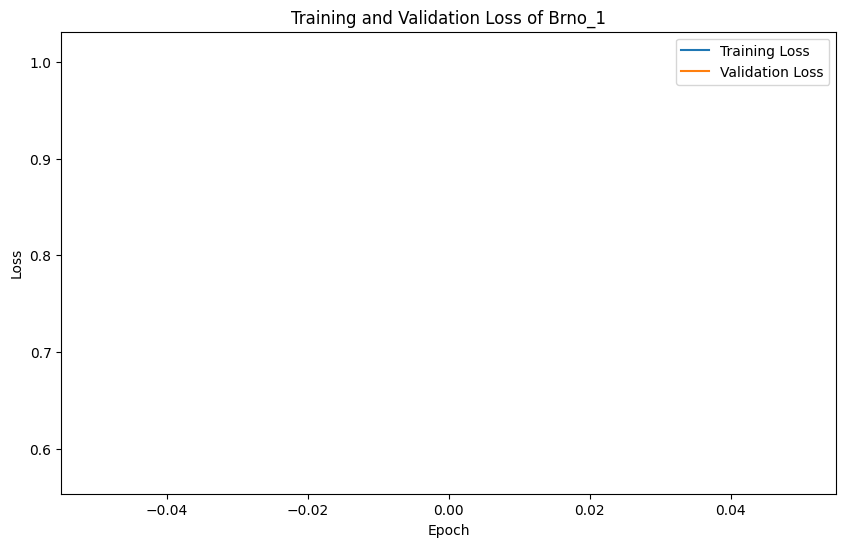

Processing data and training model for warehouse: Budapest_1
Columns: 46
1154
        day  orders_rolling_std_56  orders_lag_168  orders_lag_84  month_cos  \
0 -1.229544              -0.342920       -1.123633      -1.253163   1.572395   
1 -1.114895              -0.342920       -1.123633      -1.253163   1.572395   
2 -1.000246              -1.189231       -1.123633      -1.253163   1.572395   

    day_sin  month_sin   day_cos  orders_rolling_std_168  year_cos  year_sin  \
0  0.519429  -0.594074 -1.229544               -1.074948  -2.14543 -0.309239   
1  0.503497  -0.594074 -1.114895               -1.074948  -2.14543 -0.309239   
2  0.484667  -0.594074 -1.000246               -2.137547  -2.14543 -0.309239   

   orders_rolling_mean_56     month  orders_rolling_mean_168  day_of_year  \
0               -1.525187  1.572395                -1.584772     1.479045   
1               -1.892959  1.572395                -2.012029     1.488152   
2               -1.868786  1.572395              

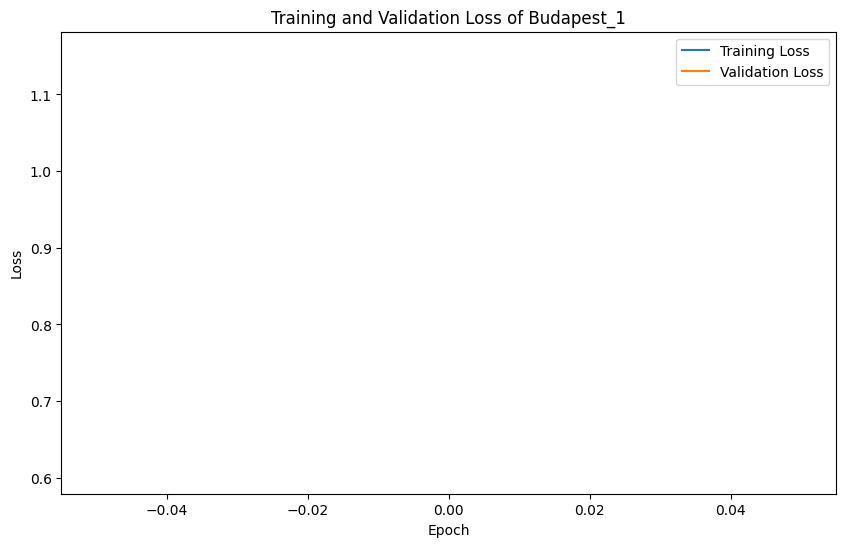

Processing data and training model for warehouse: Prague_1
Columns: 46
1193
        day  orders_rolling_std_56  orders_lag_168  orders_lag_84  month_cos  \
0 -1.211889              -1.709803       -1.140241      -1.267463   1.577677   
1 -1.097922              -1.709803       -1.140241      -1.267463   1.577677   
2 -0.983955              -1.681251       -1.140241      -1.267463   1.577677   

    day_sin  month_sin   day_cos  orders_rolling_std_168  year_cos  year_sin  \
0  0.513699  -0.595108 -1.211889               -3.219868 -2.145151  -0.30871   
1  0.497673  -0.595108 -1.097922               -3.219868 -2.145151  -0.30871   
2  0.478733  -0.595108 -0.983955               -3.175944 -2.145151  -0.30871   

   orders_rolling_mean_56     month  orders_rolling_mean_168  day_of_year  \
0               -1.739973  1.577677                -2.082228     1.483102   
1               -1.912107  1.577677                -2.306609     1.492208   
2               -1.804915  1.577677                

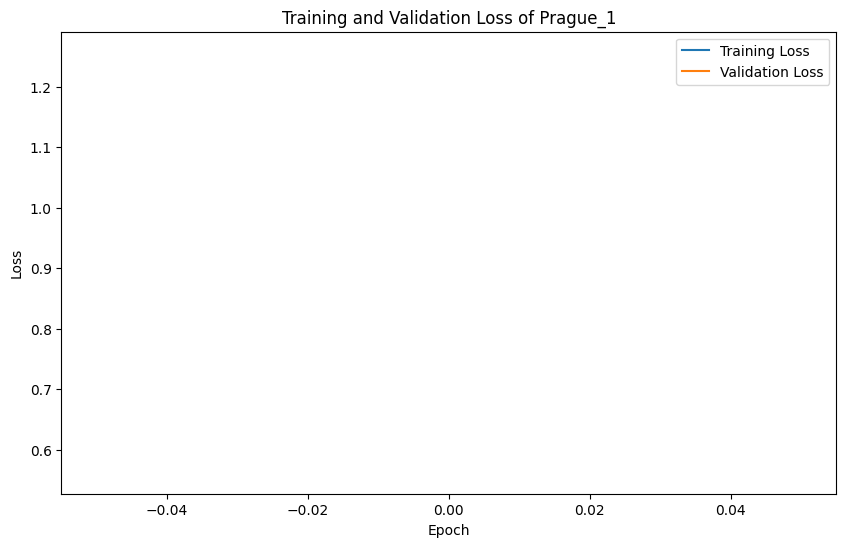

Processing data and training model for warehouse: Prague_2
Columns: 46
1193
        day  orders_rolling_std_56  orders_lag_168  orders_lag_84  month_cos  \
0 -1.211889              -2.110026        -1.19587      -1.328781   1.577677   
1 -1.097922              -2.110026        -1.19587      -1.328781   1.577677   
2 -0.983955              -1.974182        -1.19587      -1.328781   1.577677   

    day_sin  month_sin   day_cos  orders_rolling_std_168  year_cos  year_sin  \
0  0.513699  -0.595108 -1.211889               -3.642282 -2.145151  -0.30871   
1  0.497673  -0.595108 -1.097922               -3.642282 -2.145151  -0.30871   
2  0.478733  -0.595108 -0.983955               -3.443307 -2.145151  -0.30871   

   orders_rolling_mean_56     month  orders_rolling_mean_168  day_of_year  \
0               -1.818458  1.577677                -2.101254     1.483102   
1               -1.951151  1.577677                -2.268834     1.492208   
2               -2.058843  1.577677                

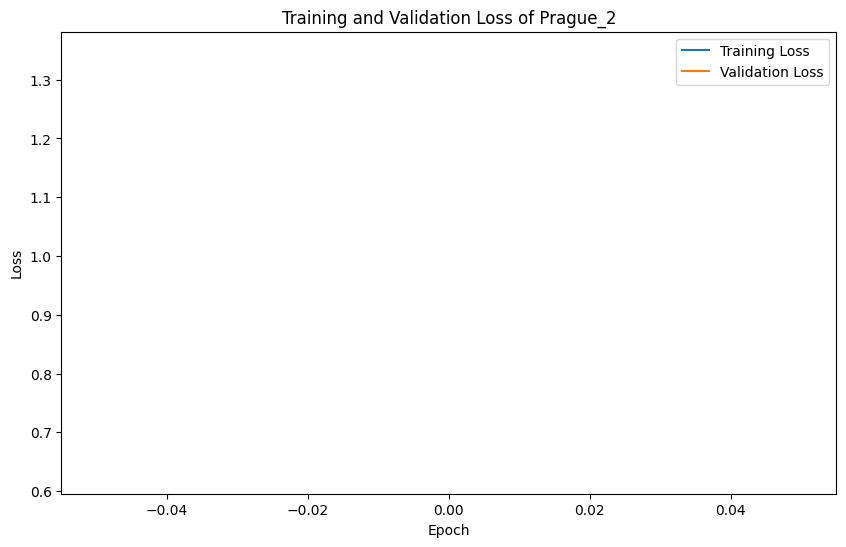

Processing data and training model for warehouse: Prague_3
Columns: 46
1193
        day  orders_rolling_std_56  orders_lag_168  orders_lag_84  month_cos  \
0 -1.211889              -2.307675       -0.835798      -0.931997   1.577677   
1 -1.097922              -2.307675       -0.835798      -0.931997   1.577677   
2 -0.983955              -2.228779       -0.835798      -0.931997   1.577677   

    day_sin  month_sin   day_cos  orders_rolling_std_168  year_cos  year_sin  \
0  0.513699  -0.595108 -1.211889               -4.327905 -2.145151  -0.30871   
1  0.497673  -0.595108 -1.097922               -4.327905 -2.145151  -0.30871   
2  0.478733  -0.595108 -0.983955               -4.202430 -2.145151  -0.30871   

   orders_rolling_mean_56     month  orders_rolling_mean_168  day_of_year  \
0               -1.367402  1.577677                -1.649415     1.483102   
1               -1.506350  1.577677                -1.834885     1.492208   
2               -1.606376  1.577677                

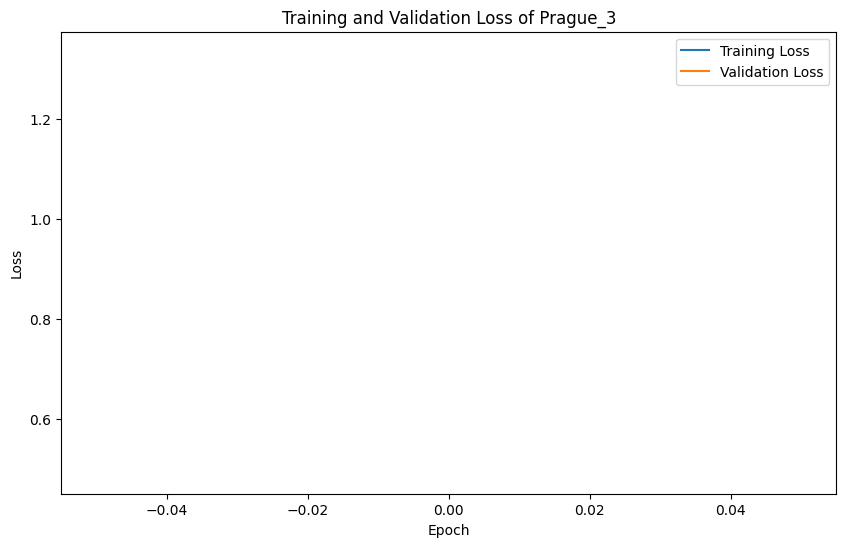

Processing data and training model for warehouse: Munich_1
Columns: 46
785
        day  orders_rolling_std_56  orders_lag_168  orders_lag_84  month_cos  \
0  0.588953              -1.910712       -1.370648      -1.561674   0.083277   
1  1.503095              -1.910712       -1.370648      -1.561674   0.083277   
2 -1.125065              -1.906880       -1.370648      -1.561674   0.359112   

    day_sin  month_sin   day_cos  orders_rolling_std_168  year_cos  year_sin  \
0  0.808843   0.322976  0.588953               -1.748054 -1.672567  1.321338   
1  0.567473   0.322976  1.503095               -1.748054 -1.672567  1.321338   
2  0.515305   0.200314 -1.125065               -1.745345 -1.672567  1.321338   

   orders_rolling_mean_56     month  orders_rolling_mean_168  day_of_year  \
0               -1.837224  0.083277                -1.968891     0.122178   
1               -1.946460  0.083277                -2.105215     0.194412   
2               -2.010071  0.359112                -

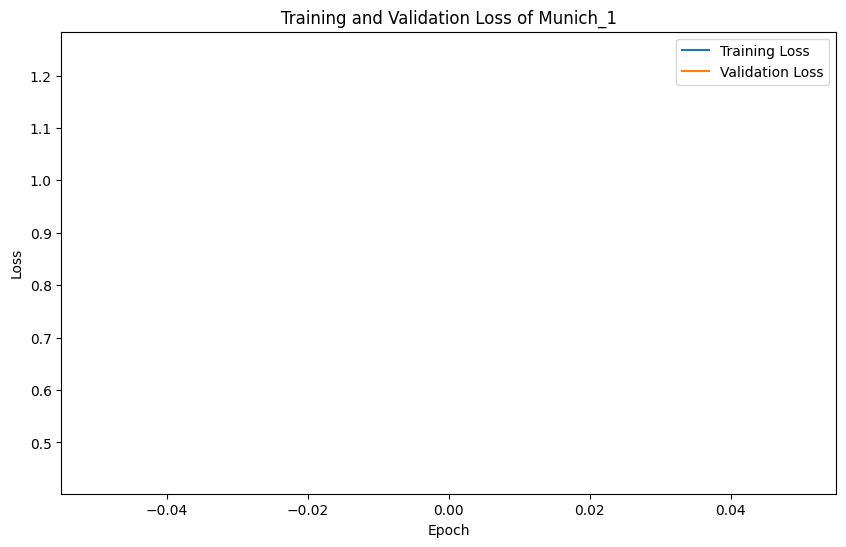

Processing data and training model for warehouse: Frankfurt_1
Columns: 46
629
        day  orders_rolling_std_56  orders_lag_168  orders_lag_84  month_cos  \
0  0.261037              -3.466942       -1.348271      -1.772184  -1.265564   
1  0.374980              -3.466942       -1.348271      -1.772184  -1.265564   
2  0.830753              -3.269554       -1.348271      -1.772184  -1.265564   

    day_sin  month_sin   day_cos  orders_rolling_std_168  year_cos  year_sin  \
0  0.095213   0.648776  0.261037               -4.397468 -1.058326 -1.058147   
1 -0.759533   0.648776  0.374980               -4.397468 -1.058326 -1.058147   
2 -1.172293   0.648776  0.830753               -4.161240 -1.058326 -1.058147   

   orders_rolling_mean_56     month  orders_rolling_mean_168  day_of_year  \
0               -2.661497 -1.265564                -2.590222    -1.226255   
1               -2.656530 -1.265564                -2.584826    -1.216808   
2               -2.631695 -1.265564              

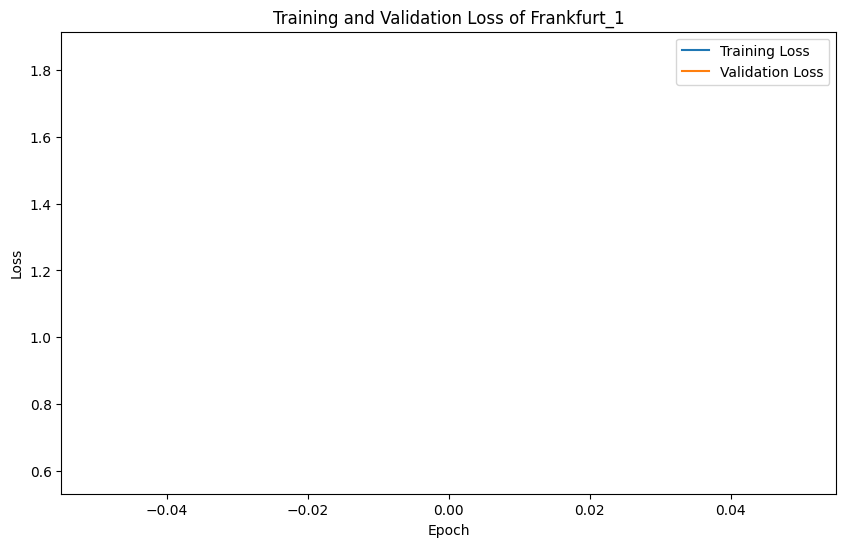

Training complete for all warehouses.


In [49]:
# Step 1: Preprocess the entire dataset
train_df_preprocessed = preprocess_data(train_df, categorical_features, x_scaler_features, binary_features)

# Step 2: Split the preprocessed data by warehouse
warehouses = train_df_preprocessed['warehouse'].unique()
warehouse_dfs = []
for warehouse in warehouses:
    warehouse_df = train_df_preprocessed[train_df_preprocessed['warehouse'] == warehouse]
    warehouse_dfs.append(warehouse_df)

# Step 3: Train models for each warehouse
val_data = {}

for warehouse, warehouse_df in zip(warehouses, warehouse_dfs):
    print(f"Processing data and training model for warehouse: {warehouse}")
    print(f"Columns: {len(warehouse_df.columns)}")
    print(len(warehouse_df))
    ## Prepare features for scaling
    X = warehouse_df.drop(columns=['orders'])
    y = warehouse_df['orders']

    x_scaler = StandardScaler()
    y_scaler = StandardScaler()
    X_scaled = x_scaler.fit_transform(X[x_scaler_features])
    y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1))
    joblib.dump(x_scaler, 'x_scaler.joblib')
    joblib.dump(y_scaler, 'y_scaler.joblib')
    #else:
    #    x_scaler = joblib.load('x_scaler.joblib')
    #    X_scaled = x_scaler.transform(X[x_scaler_features])
    #    y_scaled = None  # No target variable during inference

    # Create DataFrame with scaled features
    X_scaled_df = pd.DataFrame(X_scaled, columns=x_scaler_features)
    print(X_scaled_df.head(3))
    # Create sequences
    X_seq, y_seq = create_sequences(X_scaled_df, y_scaled, time_steps=TIME_STEPS)
    
    # Split data
    X_train, X_val, y_train, y_val = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=True, random_state=42)
    
    # Create and train model
    model = create_model(input_shape=(X_train.shape[1], X_train.shape[2]))
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True),
        ModelCheckpoint(f'model_{warehouse}.keras', save_best_only=True, monitor='val_loss', mode='min', verbose=1)
    ]
    
    # Save the val data in the "val_data" dictionary for each warehouse:
    val_data[warehouse] = (X_val, y_val)
    
    history = model.fit(
        X_train, y_train, 
        epochs=EPOCHS, 
        batch_size=BATCH_SIZE, 
        validation_data=(X_val, y_val), 
        callbacks=callbacks,
        verbose=1
    )
    
    plot_loss(history)

print("Training complete for all warehouses.")



In [ ]:
# Get a separate dataframe for every warehouse
warehouses = train_df['warehouse'].unique()
warehouse_dfs = []
for warehouse in warehouses:
    warehouse_df = train_df[train_df['warehouse'] == warehouse]
    warehouse_dfs.append(warehouse_df)

val_data = {}

for warehouse, warehouse_df in zip(warehouses, warehouse_dfs):
    print(f"Processing data and training model for warehouse: {warehouse}")
    
    # Preprocess the training data for this warehouse
    X_train_scaled, y_train_scaled = preprocess_data(warehouse_df, categorical_features, x_scaler_features, binary_features)
    
    print(f"columns: {len(X_train_scaled.columns)}")
    # Create sequences
    X_seq, y_seq = create_sequences(X_train_scaled, y_train_scaled, time_steps=TIME_STEPS)
    
    # Split data
    X_train, X_val, y_train, y_val = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=True, random_state=42)
    
    # Create and train model
    model = create_model(input_shape=(X_train.shape[1], X_train.shape[2]))
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True),
        ModelCheckpoint(f'model_{warehouse}.keras', save_best_only=True, monitor='val_loss', mode='min', verbose=1)
    ]
    
    # Save the val data in the "val_data" dictionary for each warehouse:
    val_data[warehouse] = (X_val, y_val)
    
    history = model.fit(
        X_train, y_train, 
        epochs=EPOCHS, 
        batch_size=BATCH_SIZE, 
        validation_data=(X_val, y_val), 
        callbacks=callbacks,
        verbose=1
    )
    
    plot_loss(history)

print("Training complete for all warehouses.")

In [ ]:
# Save all scaler features into singe json scaler config file:
scaler_config = {
    'bin_features': binary_features,
    'cat_features': categorical_features,
    'scaler_features': x_scaler_features,
    'training_features': X_train_scaled.columns.tolist()
}

# Save the scaler config
joblib.dump(scaler_config, 'scaler_config.joblib')

## MAPE Eval

### Visualize predictions on the training data

In [ ]:
# Load the scaler configuration and models
y_scaler = joblib.load('y_scaler.joblib')

# List of dataframes for each warehouse
warehouse_dfs = []
for warehouse in warehouses:
    warehouse_df = train_df[train_df['warehouse'] == warehouse]
    warehouse_df = warehouse_df.reset_index(drop=True)
    warehouse_dfs.append(warehouse_df)

# Process and predict for each warehouse
mape_scores = []

for warehouse_df, warehouse in zip(warehouse_dfs, warehouses):
    print(f"Predicting for warehouse: {warehouse}")
    
    # Preprocess data
    X_train_scaled, y_train_scaled = preprocess_data(warehouse_df, categorical_features, x_scaler_features, binary_features)
    
    # Create sequences
    X_seq, y_seq = create_sequences(X_train_scaled, y_train_scaled, time_steps=TIME_STEPS)
    
    # Load the model
    model = tf.keras.models.load_model(f'model_{warehouse}.keras')
    
    # Predict
    predictions = model.predict(X_seq)
    predictions = y_scaler.inverse_transform(predictions)
    y_seq_unscaled = y_scaler.inverse_transform(y_seq)
    
    # Calculate MAPE
    mape = mean_absolute_percentage_error(y_seq_unscaled, predictions) * 100
    mape_scores.append(mape)
    
    # Visualize the predictions
    plt.figure(figsize=(15, 5))
    plt.plot(y_seq_unscaled, label='True', color='black')
    plt.plot(predictions, label='Predicted', color='red')
    plt.plot(y_seq_unscaled - predictions, label='Difference', color='blue', linestyle='--')
    plt.title(f'Predictions vs True for warehouse: {warehouse}')
    plt.xlabel('Sample')
    plt.ylabel('Orders')
    plt.legend()
    plt.show()
    
    print(f'\nMean Absolute Percentage Error on training data for {warehouse}: {mape:.4f}%')

print("\nMAPE training scores: ")
for i, score in enumerate(mape_scores):
    print(f"{warehouses[i]}: {score:.4f}%")

print(f"\nMean training MAPE: {np.mean(mape_scores):.4f}%")

### Visualize predictions on the validation data

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import mean_absolute_percentage_error
import joblib

# Assuming val_data dictionary is already defined and populated during training

mape_scores = []
y_scaler = joblib.load('y_scaler.joblib')

for warehouse in warehouses:
    print(f"Predicting for warehouse: {warehouse}")
    
    # Load the validation data for the current warehouse
    X_val, y_val = val_data[warehouse]
    
    # Load the model
    model = tf.keras.models.load_model(f'model_{warehouse}.keras')
    
    # Predict
    predictions = model.predict(X_val)
    predictions = y_scaler.inverse_transform(predictions)
    y_val_unscaled = y_scaler.inverse_transform(y_val.reshape(-1, 1))
    
    # Calculate MAPE
    mape = mean_absolute_percentage_error(y_val_unscaled, predictions) * 100
    mape_scores.append(mape)
    
    # Visualise the predictions
    plt.figure(figsize=(15, 5))
    plt.plot(y_val_unscaled, label='True', color='black')
    plt.plot(predictions, label='Predicted', color='red')
    plt.plot(y_val_unscaled - predictions, label='Difference', color='blue', linestyle='--')
    plt.title(f'Predictions vs True for warehouse: {warehouse}')
    plt.xlabel('Sample')
    plt.ylabel('Orders')
    plt.legend()
    plt.show()
    
    print(f'\nMean Absolute Percentage Error on validation data for {warehouse}: {mape:.4f}%')

print("\nMAPE validation scores: ")
for i, score in enumerate(mape_scores):
    print(f"{warehouses[i]}: {score:.4f}%")

print(f"\nMean validation MAPE: {np.mean(mape_scores):.4f}%")


## Inference and visualisation on test data:

In [ ]:

def create_sequences(data, max_time_steps):

    sequences = []
    for i in range(len(data)):
        seq = data.iloc[max(0, i-max_time_steps+1):i+1].values
        if len(seq) < max_time_steps:
            padding = np.tile(seq[0], (max_time_steps - len(seq), 1))
            seq = np.vstack((padding, seq))
        sequences.append(seq)
    return np.array(sequences)


In [ ]:
def predict_multiple(data, time_steps, warehouse_models, y_scaler, training_features):
    predictions = []
    submission_data = []

    for warehouse in data['warehouse'].unique():
        if warehouse not in warehouse_models:
            print(f"No model found for warehouse: {warehouse}")
            warehouse_predictions = [np.nan] * len(data[data['warehouse'] == warehouse])
            predictions.extend(warehouse_predictions)
            continue

        model = warehouse_models[warehouse]
        wh_data = data[data['warehouse'] == warehouse].copy()
        wh_data = wh_data.reindex(columns=training_features)

        sequences = create_sequences(wh_data, time_steps)
        
        # how many sequences and what shape ?
        print(f"sequences shape: {sequences.shape}")
        
        
        # Predict on all sequences
        preds = model.predict(sequences)
        preds_rescaled = y_scaler.inverse_transform(preds)
        
        # Align predictions with original data
        wh_predictions = np.full(len(wh_data), np.nan)
        
        # Adjust predictions based on time_steps
        if time_steps > 1:
            # We only keep the last prediction for each sequence
            preds_rescaled = preds_rescaled[:, -1]
        
        # Calculate the number of predictions
        num_predictions = len(preds_rescaled)
        
        # Assign predictions, accounting for the offset due to sequence creation
        wh_predictions[-num_predictions:] = preds_rescaled.flatten()
        predictions.extend(wh_predictions)

        # Prepare submission data
        wh_submission_data = data.loc[data['warehouse'] == warehouse].copy()
        wh_submission_data['predicted_orders'] = wh_predictions
        submission_data.append(wh_submission_data)

    submission_df = pd.concat(submission_data)
    return np.array(predictions), submission_df

In [ ]:
def load_models_and_scalers(warehouses):
    warehouse_models = {}
    for wh in warehouses:
        try:
            model = tf.keras.models.load_model(f'model_{wh}.keras')
            warehouse_models[wh] = model
        except Exception as e:
            print(f"Error loading model for warehouse {wh}: {str(e)}")
    return warehouse_models

In [ ]:
X_val.shape

In [ ]:
dataframe = pd.read_csv("data/test_proc_mt.csv")
dataframe['date'] = pd.to_datetime(dataframe['date'])
dataframe = dataframe.sort_values(by=['date', 'warehouse'])
print(f"Rows: {len(dataframe)}")

In [ ]:
# load scaler config:
scaler_config = joblib.load('scaler_config.joblib') # load the scaler config
ohsc = joblib.load("onehot_scaler.joblib")   # OneHotEncoder for categorical features

x_scaler_features = scaler_config['scaler_features']   # standard scaler features in the right order that the training dataset was scaled on
categorical_features = scaler_config['cat_features']    # categorical features
binary_features = scaler_config['bin_features']    # binary features are unpluged before scaling and then plugged back in after scaling
training_features = scaler_config['training_features']
    
print(f"cat_features: {categorical_features}")
print(f"binary_features: {binary_features}")
print(f"scaler_columns: {len(x_scaler_features)}")

In [ ]:
id = dataframe['id']
date = dataframe['date']
warehouse = dataframe["warehouse"]

In [ ]:
processed_data = preprocess_data(dataframe, categorical_features, x_scaler_features, binary_features, inference=True)
processed_data = pd.concat([warehouse, processed_data], axis=1)
processed_data = processed_data.set_index(dataframe.date)
len(processed_data.columns)

In [ ]:
# Load models and scalers
warehouses = processed_data['warehouse'].unique()
warehouse_models = load_models_and_scalers(warehouses)
y_scaler = joblib.load('y_scaler.joblib')

In [ ]:
predictions, submission_df = predict_multiple(processed_data, TIME_STEPS, warehouse_models, y_scaler, training_features)

In [ ]:
# Align 'id' and 'date' with the original dataframe
dataframe = dataframe.set_index('date')
submission_df['id'] = submission_df.index.map(lambda x: dataframe.loc[x, 'id'] if x in dataframe.index else np.nan)
submission_df['date'] = submission_df.index

# Save submission CSV
submission_df.to_csv('submission_multi_warehouse.csv', index=False)

In [ ]:
len(submission_df.predicted_orders)

In [ ]:
submission_df.tail()

In [ ]:
# Plot predictions for each warehouse
train_df_raw = pd.read_csv("data/train.csv")
train_df_raw['date'] = pd.to_datetime(train_df_raw['date'])

last_year_data = train_df_raw[train_df_raw['date'].dt.year > 2022]

for wh in warehouses:

    wh_df_pred = submission_df[submission_df['warehouse'] == wh]
    wh_df_last_year = last_year_data[last_year_data['warehouse'] == wh]
    
    # Plot data (training data from 2023)

    plt.figure(figsize=(12, 6))
    
    plt.plot(wh_df_pred.index, wh_df_pred['predicted_orders'], label='Predicted',  linestyle='--', color='red')

    plt.plot(wh_df_last_year.date, wh_df_last_year['orders'], label='Actual', color='blue')

    plt.title(f'Predicted vs Actual Orders for {wh} in 2023-2024')
    plt.xlabel('Date')
    plt.ylabel('Orders')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.savefig(f'prediction_plot_{wh}.png')
    plt.show()
    plt.close()

print("Predictions complete. Submission file and plots created.")